# Optimize The Background Subtraction

In our problem, the true background density ($N_f$) is not directly estimted, we use the background density in a ring around the cluster, $\hat{N}_f$. However, as we saw in the discussion of the normalization factor, it is not always that the local background provides an unbiased estimator. 

For this reason, we propose a fit of the true background density, our only free parameter is a multiplicative bias, $f = N_f/\hat{N}_f$, which is minimized for a given cluster. 

We know the total number of galaxies in the field and we want to estimate the $N_c$ and $N_f$,
$$
N_{cf} = N_c+N_f
$$

Our estimator of the number of cluster galaxies $\hat{N}_c$ is the sum of the membership probabilties. Then, we can define our probilize as the minizmiaof cluster galaxies. The loss function is given by:

$$
L (f | model,N_f, N_{cf}) = \left| \left( N_{cf} - N_f\right) - Prior(N_c,N_f)\sum{\frac{P(R,z,c|\; \textit{member})}{P(R,z,c)}} \right|
$$

We can then assume we don't know the true background density $N_f$ and re-write the loss function in terms of $f$. Since $N_{cf}$ and $\hat{N}_f$ are given the only free variable which remains is the multiplicative bias.

$$
L (f | model,\hat{N}_f, N_{cf}) = \left| \left(N_{cf} - f \hat{N}_f\right) -Prior(N_{cf}-f\hat{N}_f,f\hat{N}_f)\sum{\frac{P(R,z,c|\; \textit{member})}{P(R,z,c)}}  \right|
$$

The loss functions as is writen depends on the prior but it does not depend on the membership probabilites per se. So, this framework allow us to perofrm the fit in a post analysis.

In [91]:
# Loss function
def prior(a,b):
    return a/(a+b)

# def loss(f, params, p=2.):
#     """A simple loss function as a function of parameters `theta`."""
    
#     x, hat_Nf, Ncf = params
#     ngals      = Ncf - f*hat_Nf
#     ngals_pred = prior(ngals,f*hat_Nf)*x
#     resid      = np.abs(ngals_pred - ngals)
#     return np.sum(resid**p)

# Copacabana 

In this lines, I'll load the copacabana output and investigate the addition of the Beta Distribution.

In [1]:
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns; sns.set(color_codes=True)
plt.rcParams.update({'font.size': 16})
sns.set_style("whitegrid")

import numpy as np
from scipy.interpolate import interp1d
import scipy

In [2]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using Modified sklearn.mixture.GMM, modified to allow data weights


In [3]:
cfg='/home/s1/jesteves/git/ccopa/config_files/config_copa_dc2.yaml'
dataset='cosmoDC2'

copa = copacabana(cfg,dataset=dataset)

In [4]:
run_name = 'gauss003-r200'
cat = copa.load_copa_out('cluster',run_name)
gal = copa.load_copa_out('members',run_name)

Matching Copa output with main and BMA


## Loading $\alpha$ and $\beta$

We're making a correction on the $n_c$ only for this purpose. In another notebook I'll investigate why $n_c$ is biased.

In [327]:
area = np.array(np.pi*cat['R200']**2)

nbkg= cat['Nbkg']

Nc = cat['Norm']
Nf = nbkg*area
Ncf= (Nc/area+nbkg)*area

Nt = cat['Ngals_true']
Nft= cat['Nbkg_true']*area

ftrue = Nft/Nf

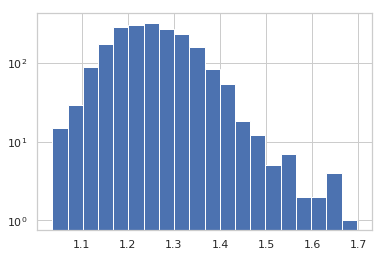

In [330]:
plt.hist((Nft+Nt)/(Nc+Nf),bins=20)
#plt.xscale('log')
plt.yscale('log')

In [331]:
np.std((Nft+Nt)/(Nc+Nf))

0.0865257608885472

In [200]:
#Ncf = (Nt+Nft)

In [354]:
alpha = np.array(Nc).copy()
beta  = np.array(Nf).copy()
prior = alpha/(alpha+beta)

In [355]:
cids = np.array(cat['CID'])
gids = np.array(gal['CID'])
r200 = np.array(cat['R200'])
zcls = np.array(cat['redshift'])
keys = list(chunks(gids,cids))
ncls = len(cat)

In [15]:
ncls    = len(cat)
columns = ['flat','beta','old']

## compute the new probabilities
cla,res = [],[]
for i in range(ncls):
    print('alpha,beta: %.2f ,%.2f'%(alpha[i],beta[i]))
    b = BayesianProbability(alpha[i],beta[i],r2=r200[i])
    b.assign_probabilities(gal[keys[i]])
    b.compute_ngals()
    
    res.append(np.sum(b.prob['Pmem']['flat'])/b.prob['prior']['flat'])
    cla.append(b)
    del b

alpha,beta: 74.80 ,10.20
alpha,beta: 21.01 ,4.10
alpha,beta: 13.11 ,8.00
alpha,beta: 21.11 ,7.19
alpha,beta: 6.29 ,1.88
alpha,beta: 59.94 ,22.59
alpha,beta: 35.33 ,6.95
alpha,beta: 3.59 ,6.85
alpha,beta: 29.05 ,7.87
alpha,beta: 4.79 ,2.89
alpha,beta: 1.80 ,3.59
alpha,beta: 68.66 ,14.22
alpha,beta: 2.66 ,4.70
alpha,beta: 13.31 ,9.35
alpha,beta: 4.61 ,3.09
alpha,beta: 1.56 ,2.82
alpha,beta: 4.93 ,3.67


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:595: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


alpha,beta: 19.44 ,7.02
alpha,beta: 8.74 ,6.23
alpha,beta: 13.98 ,4.16
alpha,beta: 7.39 ,6.02
alpha,beta: 22.98 ,8.33
alpha,beta: 4.63 ,2.56
alpha,beta: 15.93 ,8.59
alpha,beta: 57.65 ,10.29
alpha,beta: 7.46 ,4.34
alpha,beta: 33.29 ,20.41
alpha,beta: 1.86 ,2.67
alpha,beta: 31.64 ,6.61
alpha,beta: 9.84 ,5.53
alpha,beta: 14.80 ,3.48
alpha,beta: 1.80 ,2.19
alpha,beta: 2.12 ,4.15
alpha,beta: 23.24 ,6.54
alpha,beta: 13.65 ,5.40
alpha,beta: 83.46 ,11.50
alpha,beta: 5.61 ,3.85
alpha,beta: 8.34 ,4.96
alpha,beta: 6.55 ,3.56
alpha,beta: 10.57 ,2.33
alpha,beta: 3.60 ,3.89
alpha,beta: 144.49 ,11.80
alpha,beta: 7.50 ,3.35
alpha,beta: 1.85 ,2.71
alpha,beta: 0.92 ,2.48
alpha,beta: 1.58 ,2.64
alpha,beta: 30.40 ,4.21
alpha,beta: 18.40 ,6.90
alpha,beta: 7.66 ,2.33
alpha,beta: 93.42 ,23.74


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in multiply


alpha,beta: 11.94 ,3.89
alpha,beta: 89.10 ,14.02
alpha,beta: 49.49 ,10.41
alpha,beta: 1.59 ,2.22
alpha,beta: 37.43 ,7.97
alpha,beta: 5.66 ,4.43
alpha,beta: 46.30 ,27.02
alpha,beta: 12.09 ,5.05
alpha,beta: 6.32 ,3.71
alpha,beta: 23.63 ,5.76
alpha,beta: 5.41 ,2.58
alpha,beta: 39.69 ,7.74
alpha,beta: 22.80 ,9.38
alpha,beta: 7.95 ,5.75
alpha,beta: 14.57 ,2.83
alpha,beta: 38.21 ,17.44
alpha,beta: 3.24 ,1.83
alpha,beta: 3.59 ,3.62
alpha,beta: 72.51 ,22.22
alpha,beta: 14.46 ,6.71
alpha,beta: 27.38 ,7.50
alpha,beta: 9.28 ,5.44
alpha,beta: 10.61 ,4.64
alpha,beta: 10.16 ,6.74
alpha,beta: 9.85 ,5.52
alpha,beta: 7.51 ,3.77
alpha,beta: 5.72 ,2.99
alpha,beta: 31.19 ,5.46
alpha,beta: -0.53 ,2.45
alpha,beta: 12.26 ,6.71
alpha,beta: 2.65 ,2.11
alpha,beta: 20.52 ,17.30
alpha,beta: 6.53 ,3.15
alpha,beta: 6.57 ,3.54
alpha,beta: 5.44 ,1.64
alpha,beta: 2.87 ,3.92
alpha,beta: 7.58 ,2.62
alpha,beta: 35.60 ,12.06
alpha,beta: 1.42 ,2.98
alpha,beta: 7.60 ,2.83
alpha,beta: 21.80 ,6.92
alpha,beta: 5.19 ,4.39
alpha

alpha,beta: 10.46 ,6.57
alpha,beta: 9.49 ,2.63
alpha,beta: 15.09 ,6.74
alpha,beta: 24.26 ,13.56
alpha,beta: 20.95 ,6.21
alpha,beta: 46.77 ,41.56
alpha,beta: 1.29 ,2.38
alpha,beta: 5.84 ,3.57
alpha,beta: 7.19 ,6.45
alpha,beta: 19.37 ,5.22
alpha,beta: 6.79 ,2.38
alpha,beta: 39.53 ,12.85
alpha,beta: 48.69 ,8.28
alpha,beta: 77.22 ,7.23
alpha,beta: 8.41 ,3.15
alpha,beta: 7.46 ,3.99
alpha,beta: 15.76 ,8.78
alpha,beta: 35.16 ,8.80
alpha,beta: 8.96 ,7.64
alpha,beta: 16.06 ,5.98
alpha,beta: 4.33 ,4.11
alpha,beta: 3.18 ,2.28
alpha,beta: 11.84 ,3.57
alpha,beta: 4.20 ,4.44
alpha,beta: 20.69 ,6.83
alpha,beta: 22.56 ,8.26
alpha,beta: 31.17 ,15.50
alpha,beta: 14.36 ,4.68
alpha,beta: 15.04 ,10.40
alpha,beta: 12.30 ,5.80
alpha,beta: 1.09 ,2.82
alpha,beta: 7.59 ,7.14
alpha,beta: 38.64 ,12.37
alpha,beta: 10.26 ,4.72
alpha,beta: 3.59 ,5.44
alpha,beta: 9.16 ,3.42
alpha,beta: 10.24 ,3.97
alpha,beta: 26.94 ,12.37
alpha,beta: 48.23 ,8.68
alpha,beta: 21.58 ,5.99
alpha,beta: 11.40 ,2.93
alpha,beta: 7.89 ,3.36
a

alpha,beta: 9.76 ,8.12
alpha,beta: 9.69 ,4.73
alpha,beta: 11.57 ,5.80
alpha,beta: 3.09 ,4.07
alpha,beta: 18.99 ,13.70
alpha,beta: 43.25 ,8.62
alpha,beta: 10.21 ,4.02
alpha,beta: 10.56 ,10.22
alpha,beta: 56.69 ,12.18
alpha,beta: 8.00 ,9.29
alpha,beta: 13.34 ,4.19
alpha,beta: 25.25 ,12.34
alpha,beta: 6.82 ,2.27
alpha,beta: 3.39 ,4.02
alpha,beta: 7.16 ,2.92
alpha,beta: 13.49 ,6.60
alpha,beta: 19.72 ,5.89
alpha,beta: 11.05 ,4.22
alpha,beta: 37.94 ,12.07
alpha,beta: 26.46 ,6.32
alpha,beta: 0.99 ,2.09
alpha,beta: 23.61 ,7.48
alpha,beta: 19.79 ,20.79
alpha,beta: 3.98 ,2.12
alpha,beta: 27.86 ,8.59
alpha,beta: 4.49 ,6.10
alpha,beta: 15.16 ,5.41
alpha,beta: 42.64 ,34.42
alpha,beta: 1.11 ,2.75
alpha,beta: 5.25 ,3.18
alpha,beta: 12.91 ,8.84
alpha,beta: 4.62 ,2.92
alpha,beta: 4.46 ,4.49
alpha,beta: 30.89 ,7.30
alpha,beta: 51.83 ,12.84
alpha,beta: 10.42 ,10.70
alpha,beta: 13.96 ,12.34
alpha,beta: 24.27 ,9.76
alpha,beta: 17.15 ,11.93
alpha,beta: 13.62 ,4.42
alpha,beta: 10.98 ,8.36
alpha,beta: 8.32 ,2

alpha,beta: 10.29 ,5.95
alpha,beta: 1.22 ,10.41
alpha,beta: 1.78 ,4.89
alpha,beta: 13.87 ,4.39
alpha,beta: 32.75 ,5.55
alpha,beta: 8.08 ,5.55
alpha,beta: 32.49 ,20.46
alpha,beta: 19.85 ,15.67
alpha,beta: 59.92 ,27.95
alpha,beta: 13.25 ,15.77
alpha,beta: 21.72 ,6.92
alpha,beta: 29.12 ,18.62
alpha,beta: 3.53 ,5.01
alpha,beta: 1.50 ,10.69
alpha,beta: 58.87 ,20.49
alpha,beta: 2.70 ,4.96
alpha,beta: 111.76 ,16.75
alpha,beta: 11.73 ,6.29
alpha,beta: 13.40 ,5.33
alpha,beta: 25.86 ,6.76
alpha,beta: 46.74 ,8.33
alpha,beta: 8.74 ,6.27
alpha,beta: 50.10 ,13.58
alpha,beta: 9.01 ,4.04
alpha,beta: 7.42 ,7.74
alpha,beta: 43.80 ,9.76
alpha,beta: 5.73 ,6.52
alpha,beta: 49.24 ,22.74
alpha,beta: 12.50 ,3.95
alpha,beta: 25.22 ,9.97
alpha,beta: 6.90 ,7.06
alpha,beta: 55.61 ,10.84
alpha,beta: 30.22 ,9.32
alpha,beta: 18.42 ,12.38
alpha,beta: 53.01 ,13.05
alpha,beta: 16.51 ,6.13
alpha,beta: 10.16 ,8.83
alpha,beta: 28.58 ,8.36
alpha,beta: 0.39 ,3.68
alpha,beta: 17.92 ,25.16
alpha,beta: 11.64 ,3.95
alpha,beta: 

alpha,beta: 8.31 ,3.66
alpha,beta: 4.55 ,3.95
alpha,beta: 8.68 ,4.61
alpha,beta: 3.20 ,7.21
alpha,beta: 3.39 ,3.91
alpha,beta: 20.79 ,7.97
alpha,beta: 3.17 ,3.32
alpha,beta: 9.68 ,5.23
alpha,beta: 32.99 ,9.97
alpha,beta: 10.62 ,2.99
alpha,beta: 77.64 ,26.82
alpha,beta: 13.31 ,9.75
alpha,beta: 57.45 ,11.57
alpha,beta: 37.34 ,11.12
alpha,beta: 7.71 ,6.85
alpha,beta: 8.22 ,5.13
alpha,beta: 6.16 ,11.85
alpha,beta: 29.97 ,12.84
alpha,beta: 29.63 ,7.75
alpha,beta: 33.25 ,13.81
alpha,beta: 25.14 ,14.11
alpha,beta: 5.93 ,3.59
alpha,beta: 16.57 ,7.48
alpha,beta: 10.79 ,7.36
alpha,beta: 12.02 ,6.41
alpha,beta: 13.05 ,14.95
alpha,beta: 38.68 ,7.92
alpha,beta: 19.70 ,6.10
alpha,beta: 31.66 ,8.49
alpha,beta: 19.20 ,6.05
alpha,beta: 28.97 ,19.98
alpha,beta: 21.38 ,15.93
alpha,beta: 15.24 ,8.93
alpha,beta: 14.24 ,5.87
alpha,beta: 18.06 ,7.37
alpha,beta: -0.75 ,8.02
alpha,beta: 17.01 ,6.06
alpha,beta: 8.14 ,10.52
alpha,beta: 9.25 ,9.87
alpha,beta: 5.66 ,4.78
alpha,beta: 48.99 ,11.12
alpha,beta: 106.78

alpha,beta: 14.28 ,12.22
alpha,beta: 25.32 ,11.38
alpha,beta: 56.88 ,26.88
alpha,beta: 4.35 ,6.44
alpha,beta: 8.53 ,7.00
alpha,beta: 5.93 ,5.61
alpha,beta: 37.99 ,12.29
alpha,beta: 18.59 ,10.37
alpha,beta: 21.07 ,20.91
alpha,beta: 10.44 ,9.89
alpha,beta: 25.38 ,11.35
alpha,beta: 6.64 ,8.48
alpha,beta: 27.52 ,10.82
alpha,beta: 71.29 ,25.57
alpha,beta: 27.88 ,14.76
alpha,beta: 20.93 ,14.95
alpha,beta: 16.20 ,6.34
alpha,beta: 33.89 ,19.33
alpha,beta: 19.47 ,13.45
alpha,beta: 53.46 ,14.07
alpha,beta: 16.65 ,5.13
alpha,beta: 55.78 ,16.57
alpha,beta: 10.37 ,11.12
alpha,beta: 10.64 ,8.46
alpha,beta: 60.74 ,25.03
alpha,beta: 4.06 ,15.80
alpha,beta: 48.88 ,16.97
alpha,beta: 14.04 ,10.90
alpha,beta: 12.01 ,5.84
alpha,beta: 10.31 ,6.12
alpha,beta: 14.60 ,9.38
alpha,beta: 6.71 ,4.22
alpha,beta: 7.95 ,10.31
alpha,beta: 20.19 ,12.14
alpha,beta: 67.01 ,15.15
alpha,beta: 32.04 ,8.88
alpha,beta: 19.81 ,16.84
alpha,beta: 3.74 ,6.36
alpha,beta: 34.61 ,15.44
alpha,beta: 49.47 ,13.53
alpha,beta: 9.91 ,8.20

In [356]:
ngals = np.array([cla[i].prob['Ngals']['flat'] for i in range(ncls)])
x = np.array([np.sum(cla[i].prob['Pmem']['flat']) for i in range(ncls)])/prior

In [357]:
# Loss function
def Prior(a,b):
    return a/(a+b)

def get_log(x):
    xlog = np.log10(x)
    xlog[np.isinf(xlog)] = -99
    xlog[np.isnan(xlog)] = -99
    return xlog

def get_frac_residual(x,y):
    res = y/(x+1e-6)
    log_res = get_log(res)
    return res,log_res

def compute_new_gals(x,f,Ncf,Nf):
    return Prior(Ncf-f*hat_Nf,f*hat_Nf)*x

def loss(f, x, hat_Nf, Ncf, p=2., vec=False):
    """Loss function
    x: (float) sum(Pmem)/prior0 
    hat_Nf:(float) number of estimated background galaxies
    Ncf: (float) total number of galaxies in the cluster area
    """
    ngals      = Ncf #- f*hat_Nf
    ngals_pred = Prior(ngals-f*hat_Nf,f*hat_Nf)*x+f*hat_Nf
    ngals_pred = np.where(ngals_pred<0.,1e-9,ngals_pred)
    
    sigma = 0.2*ngals
    #resid = (ngals-ngals_pred)/sigma
    
    resid = np.abs(get_frac_residual(ngals,ngals_pred))[1]
    if vec:
        return np.sum((resid/np.log10(sigma))**p)
    else:
        return resid**p

# def loss(hat_Nf, x, Ncf, p=2., vec=False):
#     """Loss function
#     x: (float) sum(Pmem)/prior0 
#     hat_Nf:(float) number of estimated background galaxies
#     Ncf: (float) total number of galaxies in the cluster area
#     """
#     ngals      = Ncf #- f*hat_Nf
#     #ngals = np.where(ngals<0.,1e-9,ngals)
#     ngals_pred = prior(ngals-hat_Nf,hat_Nf)*x+hat_Nf
#     ngals_pred = np.where(ngals_pred<0.,1e-9,ngals_pred)
#     #ngals_pred = ((ngals-f*hat_Nf)/ngals)*x+f*hat_Nf
#     #resid      = np.abs( (ngals_pred - ngals) )
#     resid      = np.abs(get_frac_residual(ngals,ngals_pred))[0]
#     if vec:
#         return np.sum((resid/0.4)**p)
#     else:
#         return resid**p

In [358]:
from scipy.optimize import minimize
i=np.where(zcls>0.55)[0]
# minimize the loss function
results = minimize(loss, 1., args=(x[i],Nf[i],Ncf[i],2,True))
print(results)

      fun: 957.2904631802894
 hess_inv: array([[2.88069714e-07]])
      jac: array([1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 100
      nit: 11
     njev: 33
   status: 2
  success: False
        x: array([1.08743876])


In [359]:
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    means = (xedges[1:]+xedges[:-1])/2.
    indices = []
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

In [407]:
w = cat['Ngals']>0.
zbins = np.linspace(0.09,1.,16)
keys,zmed = get_bins(zcls[w],zbins)

fmed = np.array([np.mean(ftrue[w][i]) for i in keys])
ferr = np.array([np.std(ftrue[w][i]) for i in keys])

res = []
# for i in keys:
#     results = minimize(loss, 1., args=(x[w][i],Nf[w][i],Ncf[w][i],2,True))
#     res.append(results.x[0])

for i in range(ncls):
    results = minimize(loss, 1., args=(x[w][i],Ncf[w][i],2))
    res.append(results.x[0])

IndexError: index 2053 is out of bounds for axis 0 with size 2053

<ErrorbarContainer object of 3 artists>

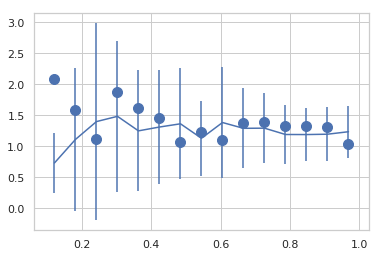

In [400]:
# resb = np.array([np.mean(np.array(res)[i]) for i in keys])

# plt.scatter(zmed,resb)
plt.scatter(zmed,np.array(res),s=100)
# plt.ylim(0.,10.)
plt.errorbar(zmed,fmed,yerr=ferr)

In [401]:
def compute_new_gals(x,f,Ncf,hat_Nf):
    return Prior(Ncf-f*hat_Nf,f*hat_Nf)*x

In [402]:
finterp = scipy.interpolate.interp1d(zmed,fmed,fill_value=(1,1), bounds_error=False)

In [403]:
fnew = finterp(zcls)
new_gals = [compute_new_gals(x[i],fnew[i],Ncf[i],Nf[i]) for i in range(ncls)]

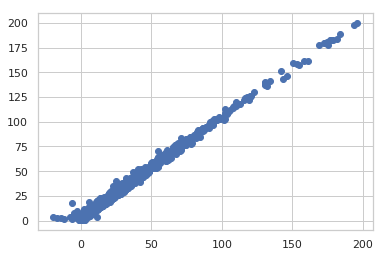

In [404]:
plt.scatter(new_gals,ngals)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


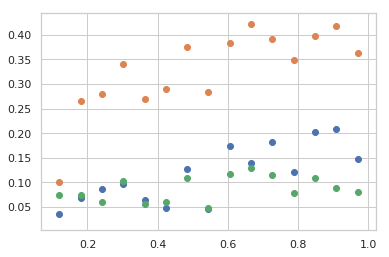

In [405]:
residual = get_frac_residual(Nt,new_gals)[0]
residual_old = get_frac_residual(Nt,ngals)[0]
residual0 = get_frac_residual(Nt,cat['Ngals'])[0]

resb = np.array([np.mean(residual[i]) for i in keys])
resbo = np.array([np.mean(residual_old[i]) for i in keys])
resb0 = np.array([np.mean(residual0[i]) for i in keys])

plt.scatter(zmed,np.abs(resb-1))
plt.scatter(zmed,np.abs(resbo-1))
plt.scatter(zmed,np.abs(resb0-1))

In [373]:
def get_variable(cat,label):
    nt0= np.array(cat['Ngals_true']).copy()
    ng0= np.array(cat[label]).copy()
    
    w, = np.where(ng0>0.)
    return nt0[w],ng0[w]

def remove_outliers(x,n=1.5):
    q25,q75 = np.nanpercentile(x,[25,75])
    iqr     = q75-q25
    lo, up  = q25-n*iqr, q75+n*iqr
    mask    = (x<up)&(x>lo)
    return mask

def get_scatter(x,xt):
    residual     = x/xt
    log_residual = np.log10(residual)
    
    check    = np.logical_not(np.isnan(log_residual) | np.isinf(log_residual))
    mask     = remove_outliers(log_residual,n=1.5)&(check)
    
    bias            = 10**np.nanmean(log_residual[mask])
    log_scatter     = np.nanstd(log_residual[mask])
    scatter         = 10**(log_scatter)-1
    
    out_fraction    = 1-1.*np.count_nonzero(mask)/len(x)
    out = {'residual':residual,'log_residual':log_residual,'bias': bias, 
           'scatter':scatter, 'log_scatter':log_scatter, 'outlier_fraction': out_fraction,'mask':mask}
    return out

def plot_scatter_distribution(cat,col,label="data",xmin=0.25,xmax=2.25,logx=False):
    ngalst, ngals = get_variable(cat,col)
    
    w = np.where(ngalst>1)[0]
    res  = get_scatter(ngals[w],ngalst[w])
    print(r'mean: %.3f'%(res['bias']))
    print(r'rms : %.3f'%(res['scatter']))
    print(r'out. frac. : %.3f'%(res['outlier_fraction']))
    
    if logx:
        xbins    = np.linspace(np.log10(xmin),np.log10(xmax),30)
        residual = res['log_residual']
        xm       = np.log10(res['bias'])
        xlo,xup  = xm-2*res['log_scatter'],xm+2*res['log_scatter']
        
    else:
        xbins = np.linspace(xmin,xmax,30)
        residual = res['residual']
        xm       = res['bias']
        xlo,xup  = 10**(np.log10(xm)-2*res['log_scatter']),10**(np.log10(xm)+2*res['log_scatter'])
    print(xbins)
    check     = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    _ = plt.hist(residual[check],bins=xbins,label='out. perc = %.2f %%'%(100*res['outlier_fraction']))
    _ = plt.hist(residual[res['mask']],bins=xbins,label=r'precision = %.2f %%'%(100*res['scatter']))
    plt.axvline(xm,color='k',ls='--')
    plt.axvline(xlo,color='r',ls='--')
    plt.axvline(xup,color='r',ls='--')
    plt.title(label)
    # plt.yscale('log')
    plt.xlabel('ratio')
    plt.legend()

mean: 1.004
rms : 0.300
out. frac. : 0.052
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


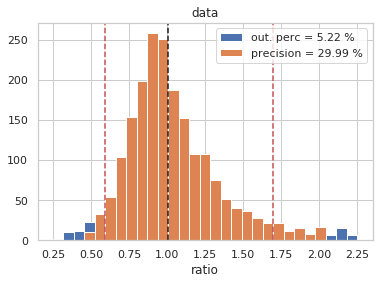

In [374]:
plot_scatter_distribution(cat,'Ngals')

In [375]:
cat['Ngals_flat']=ngals
cat['Ngals_corr']=new_gals

mean: 1.066
rms : 0.383
out. frac. : 0.043
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


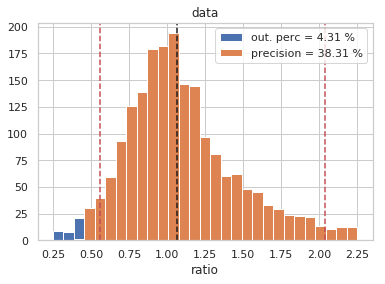

In [376]:
plot_scatter_distribution(cat,'Ngals_corr')

mean: 1.229
rms : 0.347
out. frac. : 0.029
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


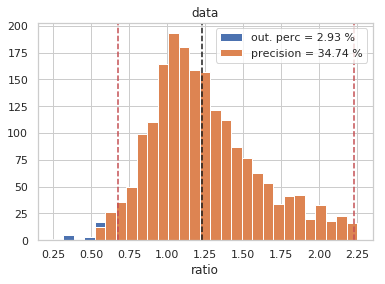

In [377]:
plot_scatter_distribution(cat,'Ngals_flat')

In [691]:
i=100
fvec = np.linspace(0.01,3.,1000)
lf   = loss(fvec, x[i],Nf[i],Ncf[i])

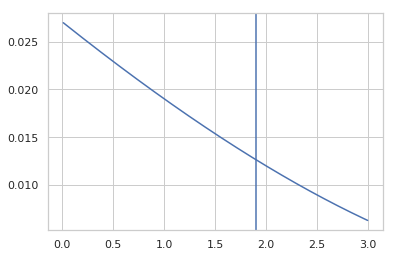

In [692]:
plt.plot(fvec,lf)
plt.axvline(ftrue[i])
#plt.axvline(2.7)

In [433]:
x[i]/Nt[i]

1.0692147057960497

In [434]:
fmax=2.
ngals      = Ncf[i] - fmax*Nf[i]
ngals_pred = prior(ngals,fmax*Nf[i])*x[i]

print(ngals)

11.710124910245298


In [435]:
Ncf[i]

46.30070881509009

In [436]:
Nt[i]

31

In [437]:
Ncf[i]-(ngals_pred+fmax*Nf[i])

3.327104854696387

In [306]:
x[i]#*ftrue[i]

112.85089911601989

In [307]:
ftrue[i]

1.3420652567565963

In [255]:
ftrue[i]

1.0915495911954882

In [128]:
results.x[0]

1.0

In [130]:
Nft[i]/Nf[i]

0.21872869242740806

(0.0, 2.0)

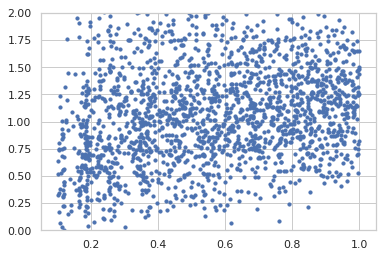

In [125]:
residual = Nft/Nf
plt.scatter(zcls,residual,s=10)
plt.ylim(0.,2.)

In [126]:
Nft[i]/Nf[i]

4.404027348150755
0.21872869242740806
1.087804888548256
0.8378338668800833
1.4404520069099909
0.23107494132952625
0.4942058746475528
1.3300429427014022
1.4447107803498418
0.9241754773603862
0.1700467596442785


In [9]:
## Correcting Nc 
## Only for test purposes

# Nc = 1.34*Nc

In [11]:
# alpha = np.array(Nt).copy()
# beta  = np.array(Nft).copy()

## Bayesian Approach: Membership probabilities

Let's compute the new membership probabilities.

In [11]:
import scipy
from scipy.interpolate import interp1d

import numpy as np
from collections import defaultdict

class BayesianProbability:
    ''' Assign Membership Probabilities For Copacabana Galaxies

    input: a, b, gal
    output: collection('prior','marginal','pdfs','pdfs_field','Pmem','Pr','Pz','Pc')

    a: Estimated number of galaxies inside the cluster area
    b: Estimated number of field galaxies inside the cluster area
    gal: table of galaxies, columns: redshift,pdf,pdfr,pdfz,pdfc
    '''
    def __init__(self, a, b, r2=1):
        self.alpha = np.where(a<=0.,.1,a)
        self.beta  = b
        self.r2    = r2
        self.betaDist = scipy.stats.beta(self.alpha, self.beta)

        self.prob  = defaultdict(dict)
        # ['prior','marginal','pdfs','pdfs_field','Pmem','Pr','Pz','Pc']

        ## init the prior
        self.compute_flat_prior()

    def load_pdfs(self,gal):
        zcls = np.array(gal['redshift']).copy()
        self.p0 = np.array(gal['Pmem']).copy()
        
        self.pdfz = np.array(gal['pdfz'][:]).copy()
        self.pdfr = np.array(gal['pdfr'][:]).copy()
        self.pdfc = get_color_pdf(zcls,gal['pdfc'][:]).copy()
        
        self.pdfzf= np.array(gal['pdfz_bkg'][:]).copy()
        self.pdfrf= np.array(gal['pdfr_bkg'][:]).copy()*(np.pi*self.r2**2)
        self.pdfcf= get_color_pdf(zcls,gal['pdfc_bkg'][:]).copy()
        
        self.pdf = filter_3pdf(self.pdfz,self.pdfc,self.pdfr)
        self.pdff= filter_3pdf(self.pdfzf,self.pdfcf,self.pdfrf)
        
    def compute_flat_prior(self):
        pm0 = self.betaDist.mean()
        priors = {'flat':pm0,'beta':None}
        self.prob['prior'] = priors

    def compute_marginal(self,name,prior_type):
        pm0 = self.prob['prior'][prior_type]
        pf,pff = self.pick_pdf(name)
        res    = pf*pm0 + pff*(1-pm0)
        self.prob['marginal'][name] = res.copy()
    
    def compute_prob(self,label,name,prior_type,eps=1e-9):
        pm0 = self.prob['prior'][prior_type]
        pdf,pdff = self.pick_pdf(name)
        mar = pdf*pm0 + pdff*(1-pm0)
        res = pdf*pm0/(mar+eps)
        pmem= filter_prob(res.copy())
        self.prob[label][prior_type] = pmem.copy()
    
    def compute_likelihood(self):
        self.pvec = np.linspace(0.,1.,1000)
        pm0   = self.prob['prior']['flat']
        radii = np.linspace(0,self.r2,100)
        pdf   = radial_pdf(radii,self.r2)
        mar   = pdf*pm0+(1-pm0)*(np.pi*self.r2**2)
        p0 = pdf*pm0/(mar+1e-9)
        self.likelihood = get_likelihood(self.pvec,p0,pdf)
    
    def pick_pdf(self,name):
        if name=='pdfr':
            return [self.pdfr,self.pdfrf]
        
        elif name=='pdfc':
            return [self.pdfc,self.pdfcf]

        elif name=='pdfz':
            return [self.pdfz,self.pdfzf]
        
        elif name=='pdf':
            return [self.pdf,self.pdff]
        else:
            print('error')
            
    def compute_beta_prior(self):
        prior = join_pdfs(self.pvec,self.likelihood,self.betaDist.pdf(self.pvec))
        pm0   = mean_pdf(self.pvec,prior)

        self.prob['prior']['beta'] = pm0
        self.prior = prior

    def assign_prob(self,name,label,prior_type):
        self.compute_marginal(name,prior_type)
        self.compute_prob(label,name,prior_type)
    
    def assign_prob_old(self,name,label):
        pdf, pdff = self.pick_pdf(name)
        if name!='Pmem':
            res = doProb(pdf, pdff, self.alpha, self.beta, normed=False)
        else:
            res = doProb(pdf, pdff, self.alpha, self.beta, normed=False)

        self.prob[label]['old'] = res.copy()
    
    def assign_probabilities(self,gal):
        self.names = ['pdf','pdfr','pdfz','pdfc']
        self.labels= ['Pmem','Pr','Pz','Pc']

        ## loading pdfs
        self.load_pdfs(gal)

        ## memb. prob. flat prior
        for label,name in zip(self.labels,self.names):
            self.assign_prob(name,label,'flat')

        ## estimating beta prior
        self.compute_likelihood()
        self.compute_beta_prior()
        
        ## memb. prob. beta prior
        for label,name in zip(self.labels,self.names):
            self.assign_prob(name,label,'beta')

        ## for check purposes
        ## old probabilities definition
        for label,name in zip(self.labels,self.names):
            self.assign_prob_old(name,label)
    
    def compute_ngals(self):
        for col in ['flat','beta','old']:
            self.prob['Ngals'][col] = np.nansum(self.prob['Pmem'][col][:]).copy()

    def plot_prior_distribution(self):
        plt.plot(self.pvec,self.betaDist.pdf(self.pvec),'b',label='Beta')
        plt.plot(self.pvec,self.likelihood,'k',label='P(model|member)')
        plt.plot(self.pvec,self.prior,'r',label='Beta*P(model|member)')
        plt.axvline(self.prob['prior']['flat'],color='b',ls='--')
        plt.axvline(self.prob['prior']['beta'],color='r',ls='--')
        plt.legend()
        plt.xlabel("Prior Probability")
        plt.ylabel('Density')
        plt.title(r'$\alpha, \beta = %.1f, %.1f$'%(self.alpha,self.beta), fontsize=16)
        pass

def interpData(x,y,x_new):
    out = interp1d(x, y, kind='linear', fill_value='extrapolate')
    return out(x_new)

def join_pdfs(x,pdf1,pdf2,eps=1e-9):
    prod = pdf1*pdf2
    norm = scipy.integrate.simps(prod,x=x)
    return prod/(norm+eps)

def mean_pdf(x,pdf):
    xmean = scipy.integrate.simps(x*pdf,x=x)
    return xmean

def get_likelihood(xnew,x,pdf,eps=1e-9):
    _,xb,pdfb = bin_data(x,pdf)
    like = interpData(xb,pdfb,xnew)
    like = np.where(np.isnan(like),0,like)
    norm = scipy.integrate.simps(like,x=xnew)
    return like/(norm+eps)

def bin_data(x,y,nbins=20):
    xbins = np.linspace(0,1.,nbins+1)#np.percentile(x,np.linspace(0,100,nbins+1))
    xmean = np.zeros_like(xbins[1:])
    ymean = np.zeros_like(xbins[1:])
    
    i=0
    for xl,xh in zip(xbins[:-1],xbins[1:]):
        w, = np.where((x>xl)&(x<=xh))
        if w.size>0:
            xmean[i] = np.nanmean(x[w])
            ymean[i] = np.nanmean(y[w])
        i+=1
    return xbins,xmean,ymean

def filter_prob(x,val=0):
    x[np.isnan(x)]=0
    x = np.where(x<0,0.,x)
    x = np.where(x>1,1.,x)
    return x

def filter_pdf(pdf):
    pdf = np.where(pdf>1e6,1e6,pdf)
    return pdf

def filter_3pdf(x,y,z):
    pdf = x*y*z
    pdf = filter_pdf(pdf)
    return pdf

## to do: smooth the color pdfs 
## https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
def get_color_pdf(zcls,pdfc):
    return np.array(np.where(zcls<0.35,pdfc[:,0],pdfc[:,2]))
#     return np.ones_like(pdfc[:,0])

### To Remove
def doProb(Pgals,Pbkg,Ngals,Nbkg, normed=True,eps=1e-12):
    ratio = (Ngals+Nbkg)/( np.sum(Ngals*Pgals) + np.sum(Nbkg*Pbkg) )
    Pgals *= ratio
    Pbkg  *= ratio
    
    if normed:
        Pgals /= (Pgals.sum()+eps)
        Pbkg  /= (Pbkg.sum()+eps)
    
    prob = (Ngals*Pgals)/(Ngals*Pgals+Nbkg*Pbkg+eps)
    # prob[np.isnan(prob)] = 0.

    prob = np.where(prob>1,1.,prob)
    prob = np.where(prob<0.,0.,prob)
    return prob
def profileNFW(R,R200,c=3):
    #Radial NFW profile implementation. Takes array of radii, value of R200,
    #and NFW concentration parameter (set to 3 by default)
    if R200>0:
        Rs=float(R200)/c
        r=R/Rs
        r=np.where(np.logical_or(r<=1e-5,r==1.),r+0.001,r)
        pre=1./((r**2)-1)
        arctan_coeff=2./(np.sqrt(np.abs(r**2-1)))
        arctan_arg=np.sqrt(np.abs((r-1)/(r+1)))
        sigma=np.where(r>1,pre*(1-arctan_coeff*np.arctan(arctan_arg)),pre*(1-arctan_coeff*np.arctanh(arctan_arg)))

        return sigma*2*Rs

    else:
        bogusval=-99.*np.ones_like(R)
        return bogusval

def radial_pdf(radii,R200,c=3.5,rc=0.2):
    radii   = np.where(radii<rc/2.,rc/2.,radii)
    density = profileNFW(radii,R200,c=c) ## without norm
    density = np.where(radii<rc,np.mean(density[radii<rc]), density)
    return density

In [10]:
def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [803]:
def set_new_columns(table,columns,val=0.):
    for col in columns:
        table[col] = val
    return table

### Prior Example

For a given cluster, we show the prior distribution.

In [778]:
cids = np.array(cat['CID'])
gids = np.array(gal['CID'])
r200 = np.array(cat['R200'])
keys = list(chunks(gids,cids))


In [53]:
ncls    = len(cat)
columns = ['flat','beta','old']

## compute the new probabilities
cla,res = [],[]
for i in range(ncls):
    print('alpha,beta: %.2f ,%.2f'%(alpha[i],beta[i]))
    b = BayesianProbability(alpha[i],beta[i],r2=r200[i])
    b.assign_probabilities(gal[keys[i]])
    b.compute_ngals()
    
    res.append(b.prob)
    cla.append(b)
    del b

alpha,beta: 74.80 ,10.20
alpha,beta: 21.01 ,4.10
alpha,beta: 13.11 ,8.00
alpha,beta: 21.11 ,7.19
alpha,beta: 6.29 ,1.88
alpha,beta: 59.94 ,22.59
alpha,beta: 35.33 ,6.95
alpha,beta: 3.59 ,6.85
alpha,beta: 29.05 ,7.87
alpha,beta: 4.79 ,2.89
alpha,beta: 1.80 ,3.59
alpha,beta: 68.66 ,14.22
alpha,beta: 2.66 ,4.70
alpha,beta: 13.31 ,9.35
alpha,beta: 4.61 ,3.09
alpha,beta: 1.56 ,2.82
alpha,beta: 4.93 ,3.67
alpha,beta: 19.44 ,7.02
alpha,beta: 8.74 ,6.23
alpha,beta: 13.98 ,4.16
alpha,beta: 7.39 ,6.02
alpha,beta: 22.98 ,8.33
alpha,beta: 4.63 ,2.56
alpha,beta: 15.93 ,8.59
alpha,beta: 57.65 ,10.29
alpha,beta: 7.46 ,4.34
alpha,beta: 33.29 ,20.41
alpha,beta: 1.86 ,2.67
alpha,beta: 31.64 ,6.61
alpha,beta: 9.84 ,5.53
alpha,beta: 14.80 ,3.48
alpha,beta: 1.80 ,2.19
alpha,beta: 2.12 ,4.15
alpha,beta: 23.24 ,6.54
alpha,beta: 13.65 ,5.40
alpha,beta: 83.46 ,11.50
alpha,beta: 5.61 ,3.85
alpha,beta: 8.34 ,4.96
alpha,beta: 6.55 ,3.56
alpha,beta: 10.57 ,2.33
alpha,beta: 3.60 ,3.89
alpha,beta: 144.49 ,11.80
alph

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in multiply


alpha,beta: 1.58 ,2.64
alpha,beta: 30.40 ,4.21
alpha,beta: 18.40 ,6.90
alpha,beta: 7.66 ,2.33
alpha,beta: 93.42 ,23.74
alpha,beta: 11.94 ,3.89
alpha,beta: 89.10 ,14.02
alpha,beta: 49.49 ,10.41
alpha,beta: 1.59 ,2.22
alpha,beta: 37.43 ,7.97
alpha,beta: 5.66 ,4.43
alpha,beta: 46.30 ,27.02
alpha,beta: 12.09 ,5.05
alpha,beta: 6.32 ,3.71
alpha,beta: 23.63 ,5.76
alpha,beta: 5.41 ,2.58
alpha,beta: 39.69 ,7.74
alpha,beta: 22.80 ,9.38
alpha,beta: 7.95 ,5.75
alpha,beta: 14.57 ,2.83
alpha,beta: 38.21 ,17.44
alpha,beta: 3.24 ,1.83
alpha,beta: 3.59 ,3.62
alpha,beta: 72.51 ,22.22
alpha,beta: 14.46 ,6.71
alpha,beta: 27.38 ,7.50
alpha,beta: 9.28 ,5.44
alpha,beta: 10.61 ,4.64
alpha,beta: 10.16 ,6.74
alpha,beta: 9.85 ,5.52
alpha,beta: 7.51 ,3.77
alpha,beta: 5.72 ,2.99
alpha,beta: 31.19 ,5.46
alpha,beta: -0.53 ,2.45
alpha,beta: 12.26 ,6.71
alpha,beta: 2.65 ,2.11
alpha,beta: 20.52 ,17.30
alpha,beta: 6.53 ,3.15
alpha,beta: 6.57 ,3.54
alpha,beta: 5.44 ,1.64
alpha,beta: 2.87 ,3.92
alpha,beta: 7.58 ,2.62
alph

alpha,beta: 13.02 ,4.82
alpha,beta: 11.18 ,3.97
alpha,beta: 10.46 ,6.57
alpha,beta: 9.49 ,2.63
alpha,beta: 15.09 ,6.74
alpha,beta: 24.26 ,13.56
alpha,beta: 20.95 ,6.21
alpha,beta: 46.77 ,41.56
alpha,beta: 1.29 ,2.38
alpha,beta: 5.84 ,3.57
alpha,beta: 7.19 ,6.45
alpha,beta: 19.37 ,5.22
alpha,beta: 6.79 ,2.38
alpha,beta: 39.53 ,12.85
alpha,beta: 48.69 ,8.28
alpha,beta: 77.22 ,7.23
alpha,beta: 8.41 ,3.15
alpha,beta: 7.46 ,3.99
alpha,beta: 15.76 ,8.78
alpha,beta: 35.16 ,8.80
alpha,beta: 8.96 ,7.64
alpha,beta: 16.06 ,5.98
alpha,beta: 4.33 ,4.11
alpha,beta: 3.18 ,2.28
alpha,beta: 11.84 ,3.57
alpha,beta: 4.20 ,4.44
alpha,beta: 20.69 ,6.83
alpha,beta: 22.56 ,8.26
alpha,beta: 31.17 ,15.50
alpha,beta: 14.36 ,4.68
alpha,beta: 15.04 ,10.40
alpha,beta: 12.30 ,5.80
alpha,beta: 1.09 ,2.82
alpha,beta: 7.59 ,7.14
alpha,beta: 38.64 ,12.37
alpha,beta: 10.26 ,4.72
alpha,beta: 3.59 ,5.44
alpha,beta: 9.16 ,3.42
alpha,beta: 10.24 ,3.97
alpha,beta: 26.94 ,12.37
alpha,beta: 48.23 ,8.68
alpha,beta: 21.58 ,5.99


alpha,beta: 29.73 ,20.77
alpha,beta: 21.62 ,14.51
alpha,beta: 79.22 ,10.56
alpha,beta: 0.76 ,3.31
alpha,beta: 23.27 ,11.82
alpha,beta: 42.43 ,10.22
alpha,beta: 9.41 ,2.76
alpha,beta: 7.50 ,2.61
alpha,beta: 34.23 ,16.19
alpha,beta: 1.70 ,1.91
alpha,beta: 9.26 ,4.66
alpha,beta: 5.58 ,4.92
alpha,beta: 9.76 ,8.12
alpha,beta: 9.69 ,4.73
alpha,beta: 11.57 ,5.80
alpha,beta: 3.09 ,4.07
alpha,beta: 18.99 ,13.70
alpha,beta: 43.25 ,8.62
alpha,beta: 10.21 ,4.02
alpha,beta: 10.56 ,10.22
alpha,beta: 56.69 ,12.18
alpha,beta: 8.00 ,9.29
alpha,beta: 13.34 ,4.19
alpha,beta: 25.25 ,12.34
alpha,beta: 6.82 ,2.27
alpha,beta: 3.39 ,4.02
alpha,beta: 7.16 ,2.92
alpha,beta: 13.49 ,6.60
alpha,beta: 19.72 ,5.89
alpha,beta: 11.05 ,4.22
alpha,beta: 37.94 ,12.07
alpha,beta: 26.46 ,6.32
alpha,beta: 0.99 ,2.09
alpha,beta: 23.61 ,7.48
alpha,beta: 19.79 ,20.79
alpha,beta: 3.98 ,2.12
alpha,beta: 27.86 ,8.59
alpha,beta: 4.49 ,6.10
alpha,beta: 15.16 ,5.41
alpha,beta: 42.64 ,34.42
alpha,beta: 1.11 ,2.75
alpha,beta: 5.25 ,3.

alpha,beta: 8.34 ,3.17
alpha,beta: 41.31 ,11.21
alpha,beta: 14.33 ,14.27
alpha,beta: 43.47 ,7.84
alpha,beta: 81.86 ,21.19
alpha,beta: 58.56 ,29.78
alpha,beta: 20.17 ,4.89
alpha,beta: 75.75 ,8.29
alpha,beta: 52.86 ,16.81
alpha,beta: 26.18 ,18.65
alpha,beta: 13.81 ,7.61
alpha,beta: 8.25 ,4.10
alpha,beta: 65.42 ,21.67
alpha,beta: 9.41 ,4.87
alpha,beta: 10.67 ,5.52
alpha,beta: 4.29 ,5.97
alpha,beta: 8.24 ,5.42
alpha,beta: 10.29 ,5.95
alpha,beta: 1.22 ,10.41
alpha,beta: 1.78 ,4.89
alpha,beta: 13.87 ,4.39
alpha,beta: 32.75 ,5.55
alpha,beta: 8.08 ,5.55
alpha,beta: 32.49 ,20.46
alpha,beta: 19.85 ,15.67
alpha,beta: 59.92 ,27.95
alpha,beta: 13.25 ,15.77
alpha,beta: 21.72 ,6.92
alpha,beta: 29.12 ,18.62
alpha,beta: 3.53 ,5.01
alpha,beta: 1.50 ,10.69
alpha,beta: 58.87 ,20.49
alpha,beta: 2.70 ,4.96
alpha,beta: 111.76 ,16.75
alpha,beta: 11.73 ,6.29
alpha,beta: 13.40 ,5.33
alpha,beta: 25.86 ,6.76
alpha,beta: 46.74 ,8.33
alpha,beta: 8.74 ,6.27
alpha,beta: 50.10 ,13.58
alpha,beta: 9.01 ,4.04
alpha,beta:

alpha,beta: 35.08 ,16.00
alpha,beta: 7.93 ,9.14
alpha,beta: 4.91 ,9.38
alpha,beta: 10.86 ,7.45
alpha,beta: 9.34 ,7.62
alpha,beta: 41.52 ,10.60
alpha,beta: 54.02 ,19.89
alpha,beta: 13.27 ,3.66
alpha,beta: 37.63 ,8.27
alpha,beta: 4.07 ,6.74
alpha,beta: 22.15 ,8.91
alpha,beta: 112.68 ,18.12
alpha,beta: 11.96 ,9.19
alpha,beta: 18.01 ,10.71
alpha,beta: 15.86 ,6.21
alpha,beta: 14.45 ,3.62
alpha,beta: 41.91 ,12.44
alpha,beta: 25.50 ,11.79
alpha,beta: 94.69 ,24.79
alpha,beta: 21.54 ,6.62
alpha,beta: 8.31 ,3.66
alpha,beta: 4.55 ,3.95
alpha,beta: 8.68 ,4.61
alpha,beta: 3.20 ,7.21
alpha,beta: 3.39 ,3.91
alpha,beta: 20.79 ,7.97
alpha,beta: 3.17 ,3.32
alpha,beta: 9.68 ,5.23
alpha,beta: 32.99 ,9.97
alpha,beta: 10.62 ,2.99
alpha,beta: 77.64 ,26.82
alpha,beta: 13.31 ,9.75
alpha,beta: 57.45 ,11.57
alpha,beta: 37.34 ,11.12
alpha,beta: 7.71 ,6.85
alpha,beta: 8.22 ,5.13
alpha,beta: 6.16 ,11.85
alpha,beta: 29.97 ,12.84
alpha,beta: 29.63 ,7.75
alpha,beta: 33.25 ,13.81
alpha,beta: 25.14 ,14.11
alpha,beta: 5.

alpha,beta: 35.03 ,16.99
alpha,beta: 27.92 ,31.02
alpha,beta: 79.84 ,15.59
alpha,beta: 20.52 ,9.22
alpha,beta: 11.57 ,9.38
alpha,beta: 9.01 ,5.25
alpha,beta: 6.65 ,5.43
alpha,beta: 42.63 ,15.14
alpha,beta: 48.55 ,14.98
alpha,beta: 10.50 ,5.03
alpha,beta: 39.64 ,13.99
alpha,beta: 12.76 ,12.83
alpha,beta: 6.51 ,5.77
alpha,beta: 11.12 ,7.90
alpha,beta: 16.59 ,5.17
alpha,beta: 6.45 ,4.91
alpha,beta: 7.67 ,5.82
alpha,beta: 14.54 ,7.62
alpha,beta: 15.87 ,6.24
alpha,beta: 5.91 ,5.29
alpha,beta: 4.08 ,6.82
alpha,beta: 22.12 ,32.68
alpha,beta: 14.28 ,12.22
alpha,beta: 25.32 ,11.38
alpha,beta: 56.88 ,26.88
alpha,beta: 4.35 ,6.44
alpha,beta: 8.53 ,7.00
alpha,beta: 5.93 ,5.61
alpha,beta: 37.99 ,12.29
alpha,beta: 18.59 ,10.37
alpha,beta: 21.07 ,20.91
alpha,beta: 10.44 ,9.89
alpha,beta: 25.38 ,11.35
alpha,beta: 6.64 ,8.48
alpha,beta: 27.52 ,10.82
alpha,beta: 71.29 ,25.57
alpha,beta: 27.88 ,14.76
alpha,beta: 20.93 ,14.95
alpha,beta: 16.20 ,6.34
alpha,beta: 33.89 ,19.33
alpha,beta: 19.47 ,13.45
alpha,

### Comparing The Prior Choices:

Here we compare the difference between the two choices of priors, flat and beta.

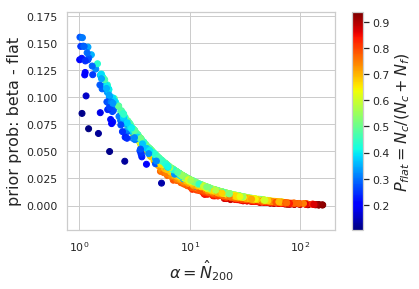

In [68]:
pflat = np.array([res[i]['prior']['flat'] for i in range(ncls)])
pbeta = np.array([res[i]['prior']['beta'] for i in range(ncls)])

plt.scatter(alpha,(pbeta-pflat),c=pflat,cmap='jet')
plt.xscale('log')
plt.ylabel('prior prob: beta - flat',fontsize=16)
plt.xlabel(r'$\alpha = \hat{N}_{c}$',fontsize=16)
plt.colorbar().set_label(r'$P_{flat}=N_c/(N_c+N_f)$',fontsize=16)

The prior prob. difference is below 2.5% for $\alpha>10$, for lower values the difference can be up to 15%, which is signficant. 


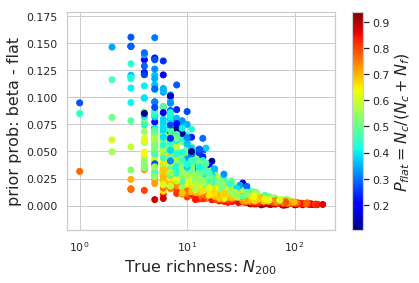

In [67]:
pflat = np.array([res[i]['prior']['flat'] for i in range(ncls)])
pbeta = np.array([res[i]['prior']['beta'] for i in range(ncls)])

plt.scatter(Nt,(pbeta-pflat),c=pflat,cmap='jet')
plt.xscale('log')
plt.ylabel('prior prob: beta - flat',fontsize=16)
plt.xlabel(r'True richness: $N_{200}$',fontsize=16)
plt.colorbar().set_label(r'$P_{flat}=N_c/(N_c+N_f)$',fontsize=16)

The prior choice has its impact on recovering the true richness. The main difference is on the low signal-to-noise ratio cases, i.e. higher number of fields galaxies than cluster galaxies ($P_{flat}<0.5$).

## Comparing the richness

Here we compare the richness for the different estimators, old method, flat and beta priors.

In [109]:
## assign the new probabilities
gal = set_new_columns(gal,columns,val=-99.)
cat = set_new_columns(cat,['Ngals_%s'%c for c in columns],val=-99.)
cat = set_new_columns(cat,[c for c in ['flat','beta']],val=-99.)

for i in range(ncls):
    for col in columns:
        gal[col][keys[i]]  = res[i]['Pmem'][col][:]
        cat['Ngals_%s'%col][i]= res[i]['Ngals'][col]
    
    for col in ['flat','beta']:
        cat[col][i]= res[i]['prior'][col]

In [111]:
def compute_ptaken(g0,label='Pmem'):
	"""
	it computes p_taken
	"""
	print('compute ptaken')
	# g0.sort('Pmem')
	pmem = g0[label]
	ptaken = np.ones_like(pmem,dtype=float)

	## find common galaxies
	gid = np.array(g0['GID'])#.astype(np.int)
	commonGroups = commonValues(gid)

	for indices in commonGroups:
		pm_group = np.array(pmem[indices])
		pt_group = np.array(ptaken[indices])

		idx_sort = np.argsort(-1*pm_group) ## -1* to reverse order

		pm_group_s = pm_group[idx_sort]
		pt_group_s = pt_group[idx_sort]

		new_pm = 0
		toto = 1
		pm = []
		for i in range(indices.size):
			toto *= (1-new_pm)
			new_pm = toto*pm_group_s[i]
			pt_group_s[i] = toto
			pm.append(new_pm)

		pmem[indices[idx_sort]] = np.array(pm)
		ptaken[indices[idx_sort]] = pt_group_s

	g0[label] = pmem
	#g0['Ptaken'] = ptaken

	return g0

def commonValues(values):
	idx_sort = np.argsort(values)
	sorted_values = values[idx_sort]
	vals, idx_start, count = np.unique(sorted_values, return_counts=True,
                                return_index=True)

	# sets of indices
	res = np.split(idx_sort, idx_start[1:])
	#filter them with respect to their size, keeping only items occurring more than once

	vals = vals[count > 1]
	commonValuesIndicies = [ri for ri in res if ri.size>1]
	
	return commonValuesIndicies


In [112]:
for col in ['flat','beta','old']:
    gal = compute_ptaken(gal,col)

compute ptaken
compute ptaken
compute ptaken


In [113]:
for i in range(ncls):
    for col in ['flat','beta','old']:
        cat['Ngals_%s'] = np.nansum(gal[col][keys[i]])

### $N_{200}$ depends on the prior choice?


In [149]:
def plot_residual(cat,labela,labelb):
    na, nb = cat['Ngals_%s'%labela],cat['Ngals_%s'%labelb]
    w, = np.where((na>0)&(nb>0))
    pflat  = cat['flat'][w]
    
    x = cat['Ngals_true'][w]
    frac_difference = (na[w]-nb[w])#/nb
    
    plt.scatter(x,frac_difference,c=pflat,cmap='jet')
    plt.axhline(0.,color='k',ls='--')
    plt.xlim(.5,300.)
    plt.xscale('log')
    plt.ylabel(r'$N_{200,%s} - N_{200,%s}$'%(labela,labelb),fontsize=16)
    plt.xlabel(r'True richness: $N_{200}$',fontsize=16)
    plt.colorbar().set_label(r'$P_{flat}=N_c/(N_c+N_f)$',fontsize=16)

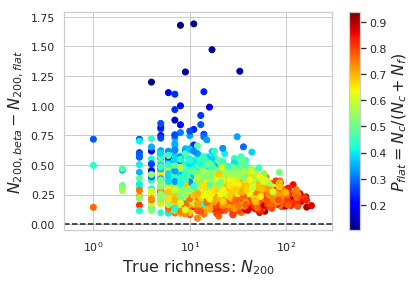

In [150]:
plot_residual(cat,'beta','flat')

The net effect on $N_{200}$ is not significant.

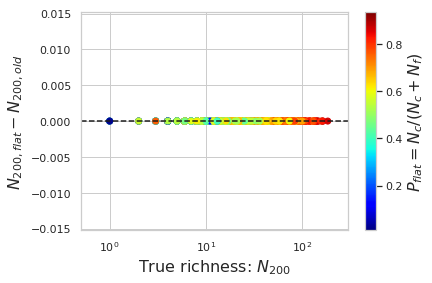

In [152]:
plot_residual(cat,'flat','old')

Check if the code old prob. definition is consitenty with the new definition.

In [1]:
plt.scatter(cat['Ngals_true'],cat['Ngals'],alpha=0.3)
plt.plot([0.5,300.],[0.5,300.],'k--')
plt.xlim(0.5,300.)
plt.ylim(0.5,300.)
plt.xscale('log')
plt.yscale('log')

NameError: name 'plt' is not defined

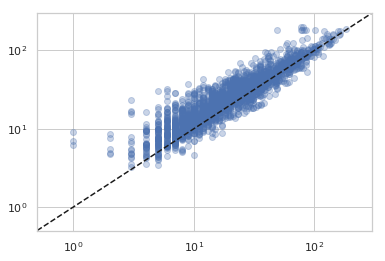

In [154]:
plt.scatter(cat['Ngals_true'],cat['Ngals_beta'],alpha=0.3)
plt.plot([0.5,300.],[0.5,300.],'k--')
plt.xlim(0.5,300.)
plt.ylim(0.5,300.)
plt.xscale('log')
plt.yscale('log')

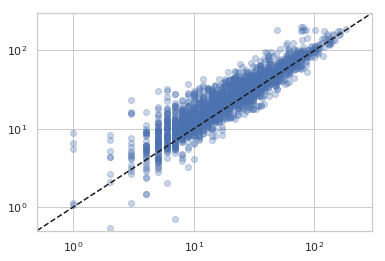

In [155]:
plt.scatter(cat['Ngals_true'],cat['Ngals_old'],alpha=0.3)
plt.plot([0.5,300.],[0.5,300.],'k--')
plt.xlim(0.5,300.)
plt.ylim(0.5,300.)
plt.xscale('log')
plt.yscale('log')

In [156]:
def get_variable(cat,label):
    nt0= np.array(cat['Ngals_true']).copy()
    ng0= np.array(cat[label]).copy()
    
    w, = np.where(ng0>0.)
    return nt0[w],ng0[w]

def remove_outliers(x,n=1.5):
    q25,q75 = np.nanpercentile(x,[25,75])
    iqr     = q75-q25
    lo, up  = q25-n*iqr, q75+n*iqr
    mask    = (x<up)&(x>lo)
    return mask

def get_scatter(x,xt):
    residual     = x/xt
    log_residual = np.log10(residual)
    
    check    = np.logical_not(np.isnan(log_residual) | np.isinf(log_residual))
    mask     = remove_outliers(log_residual,n=1.5)&(check)
    
    bias            = 10**np.nanmean(log_residual[mask])
    log_scatter     = np.nanstd(log_residual[mask])
    scatter         = 10**(log_scatter)-1
    
    out_fraction    = 1-1.*np.count_nonzero(mask)/len(x)
    out = {'residual':residual,'log_residual':log_residual,'bias': bias, 
           'scatter':scatter, 'log_scatter':log_scatter, 'outlier_fraction': out_fraction,'mask':mask}
    return out

def plot_scatter_distribution(cat,col,label="data",xmin=0.25,xmax=2.25,logx=False):
    ngalst, ngals = get_variable(cat,col)
    
    w = np.where(ngalst>1)[0]
    res  = get_scatter(ngals[w],ngalst[w])
    print(r'mean: %.3f'%(res['bias']))
    print(r'rms : %.3f'%(res['scatter']))
    print(r'out. frac. : %.3f'%(res['outlier_fraction']))
    
    if logx:
        xbins    = np.linspace(np.log10(xmin),np.log10(xmax),30)
        residual = res['log_residual']
        xm       = np.log10(res['bias'])
        xlo,xup  = xm-2*res['log_scatter'],xm+2*res['log_scatter']
        
    else:
        xbins = np.linspace(xmin,xmax,30)
        residual = res['residual']
        xm       = res['bias']
        xlo,xup  = 10**(np.log10(xm)-2*res['log_scatter']),10**(np.log10(xm)+2*res['log_scatter'])
    print(xbins)
    check     = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    _ = plt.hist(residual[check],bins=xbins,label='out. perc = %.2f %%'%(100*res['outlier_fraction']))
    _ = plt.hist(residual[res['mask']],bins=xbins,label=r'precision = %.2f %%'%(100*res['scatter']))
    plt.axvline(xm,color='k',ls='--')
    plt.axvline(xlo,color='r',ls='--')
    plt.axvline(xup,color='r',ls='--')
    plt.title(label)
    # plt.yscale('log')
    plt.xlabel('ratio')
    plt.legend()

mean: 1.004
rms : 0.300
out. frac. : 0.052
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


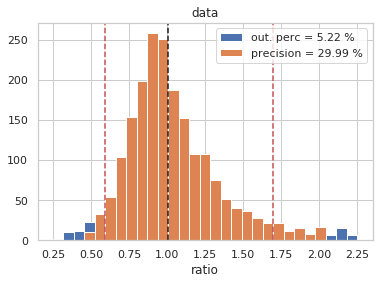

In [157]:
plot_scatter_distribution(cat,'Ngals')

mean: 1.255
rms : 0.342
out. frac. : 0.024
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


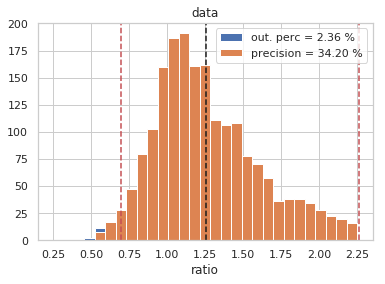

In [158]:
plot_scatter_distribution(cat,'Ngals_beta')

mean: 1.229
rms : 0.347
out. frac. : 0.029
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


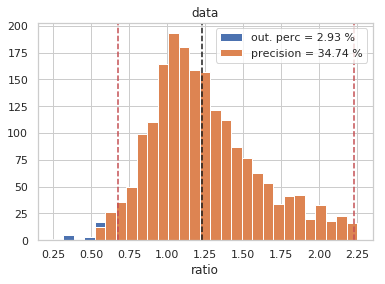

In [159]:
plot_scatter_distribution(cat,'Ngals_flat')

mean: 1.229
rms : 0.347
out. frac. : 0.029
[0.25       0.31896552 0.38793103 0.45689655 0.52586207 0.59482759
 0.6637931  0.73275862 0.80172414 0.87068966 0.93965517 1.00862069
 1.07758621 1.14655172 1.21551724 1.28448276 1.35344828 1.42241379
 1.49137931 1.56034483 1.62931034 1.69827586 1.76724138 1.8362069
 1.90517241 1.97413793 2.04310345 2.11206897 2.18103448 2.25      ]


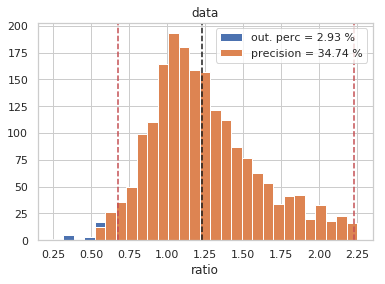

In [160]:
plot_scatter_distribution(cat,'Ngals_old')

In [161]:
def plot_fraction_pmem(galaxies,lcol='Pmem',color='r',label='_noLabel_',save=False):
    pmem = galaxies[lcol]
    mask = galaxies['True']==True

    pmem_edges = np.arange(0.0,1.1,0.1)
    idx, x_bin = makeBin(pmem, pmem_edges)
    fraction_bin = [len(galaxies[ix][mask[ix]])/(len(galaxies[ix])+1e-9) for ix in idx ]

    # fig = plt.figure(figsize=(6,6))
    plt.scatter(x_bin,fraction_bin,color=color,s=50,label=label)
    plt.plot(np.linspace(0,1.,100),np.linspace(0,1.,100),linestyle='--',color='k')

def makeBin(variable, xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins


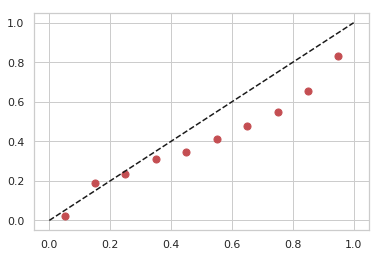

In [162]:
plot_fraction_pmem(gal,'beta')

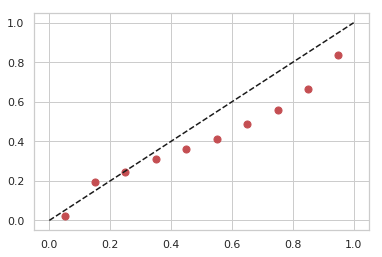

In [163]:
plot_fraction_pmem(gal,'flat')

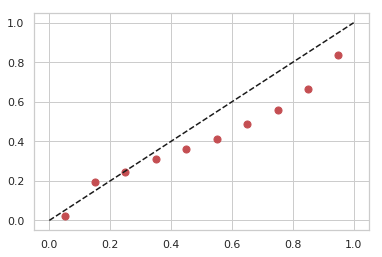

In [164]:
plot_fraction_pmem(gal,'old')

In [ ]:
# plt.plot(pvec,b.pr0.pdf(pvec))
# plt.plot(pvec,b.prior)

# plt.axvline(b.pr0.mean())
# plt.axvline(b.pm0,color='r')

In [ ]:
ncls   = len(cat)
columns = ['flat','beta','old']

## compute the new probabilities
res = []
for i in range(ncls):
    print('alpha,beta: %.2f ,%.2f'%(alpha[i],beta[i]))
    b = bayes_prob(alpha[i],beta[i])
    b.load_likelihood(gal[keys[i]])
    b.get_probabilities()
    b.compute_ngals()
    res.append(b.probabilities)
    del b
    
## assign the new probabilities
gal = set_new_columns(gal,columns,val=-99.)
cat = set_new_columns(cat,['Ngals_%s'%c for c in columns],val=-99.)

for i in range(ncls):
    for col in columns:
        gal[col][keys[i]]  = res[i][col][:]
        cat['Ngals_%s'%col][i]= res[i]['Ngals_%s'%col]

## Testing the Prior Distributions

To understand the differences between the models first, we make a set of fake data. A very simply setup, a grid of 100 points for each variable $N_c$ and $N_f$.

In [ ]:
import numpy as np
from scipy.stats import beta